<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural - Bert Sentiment Analysis

[Ejemplo similar en Pytorch](https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S#scrollTo=m_mRflxPl32F)

Este notebook pertenece al desafío N° 5 del curso de Procesamiento del Lenguaje Natural de la carrera de Especialización en Inteligencia Artificial de la UBA. El objetivo es desarrollar un modelo de clasificación de sentimientos sobre un dataset de reseñas de aplicaciones, utilizando BERT para capturar el contexto y el significado de las palabras.

>Nota: Este notebook fue diseñado para ser ejecutado en Google Colab, y se recomienda que el usuario también lo ejecute allí para asegurar la compatibilidad.

## Definición de funciones y librerias a utilizar

In [1]:
# Import google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
!pip install keras==2.15.0
os.environ['TF_USE_LEGACY_KERAS'] = '1'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.17.0 requires keras>=3.2.0, but you have keras 2.15.0 which is incompatible.


In [3]:
import tensorflow
from transformers import TFBertModel

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from transformers import InputExample, InputFeatures  # Métodos para transformar el dataset
from transformers import BertTokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical


In [4]:
def plot_train_metrics(history):
    epoch_count = range(1, len(history.history['accuracy']) + 1)
    sns.lineplot(x=epoch_count,  y=history.history['accuracy'], label='train')
    sns.lineplot(x=epoch_count,  y=history.history['val_accuracy'], label='valid')
    plt.show()

In [5]:
def convert_data_to_examples(text, labels, idx_train, idx_val):
    # Armamos un "InputExample" para los datos de entrenamiento y validación
    train_InputExamples = [InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = text[i],
                                                          text_b = None,
                                                          label = labels[i]) for i in idx_train]

    validation_InputExamples = [InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = text[i],
                                                          text_b = None,
                                                          label = labels[i]) for i in idx_val]

    return train_InputExamples, validation_InputExamples


def convert_examples_to_tf_dataset(examples, bert_tokenizer, max_length=512):
    # Transformamos los datos de entrada en tensorres de:
    # input_ids --> token id
    # attention_mask
    # token type
    features = []

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = bert_tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=False,
            return_attention_mask=True,
            padding='max_length', # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, attention_mask = (input_dict["input_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, label=e.label
            )
        )

    def gen():
    # Función generadora para no levantar todos los datos en un instante
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                },
                f.label,
            )

    return tensorflow.data.Dataset.from_generator(
        # Tensorflow dataset generator (basado en el generador y en el esquema de datos definido)
        gen,
        ({"input_ids": tensorflow.int32, "attention_mask": tensorflow.int32}, tensorflow.float32),
        (
            {
                "input_ids": tensorflow.TensorShape([None]),
                "attention_mask": tensorflow.TensorShape([None]),
            },
            tensorflow.TensorShape([output_shape]),
        ),
    )

---
## Preparación de los datos de entrenamiento

A continuación, descargaremos los datasets necesarios y realizaremos el preprocesamiento para entrenar el modelo. Además, incluiremos la limpieza de datos para una clasificación en tres categorías.

In [6]:
# Descargar la carpeta de dataset
!curl -L -o 'apps.csv' 'https://drive.google.com/u/0/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV&export=download&confirm=t'
!curl -L -o 'reviews.csv' 'https://drive.google.com/u/0/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv&export=download&confirm=t'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  131k  100  131k    0     0  58404      0  0:00:02  0:00:02 --:--:--  134k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 7002k  100 7002k    0     0   526k      0  0:00:13  0:00:13 --:--:-- 1755k


In [7]:
# Armar el dataset
df = pd.read_csv('reviews.csv')
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [8]:
print("Cantidad de críticas:", len(df))

Cantidad de críticas: 15746


<Axes: xlabel='score', ylabel='count'>

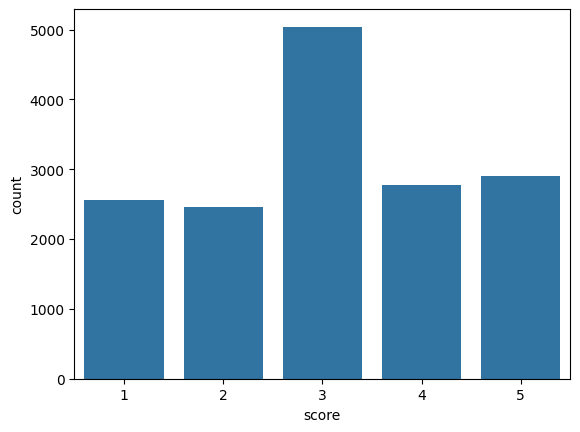

In [9]:
# ¿Cómo están balanceados los datos?
sns.countplot(x=df.score)

In [10]:
# Balancear los datos
df['sentiment'] = df.score.apply(lambda x: 0 if x <=2 else 1 if x == 3 else 2)
class_names = ['negative', 'neutral', 'positive']

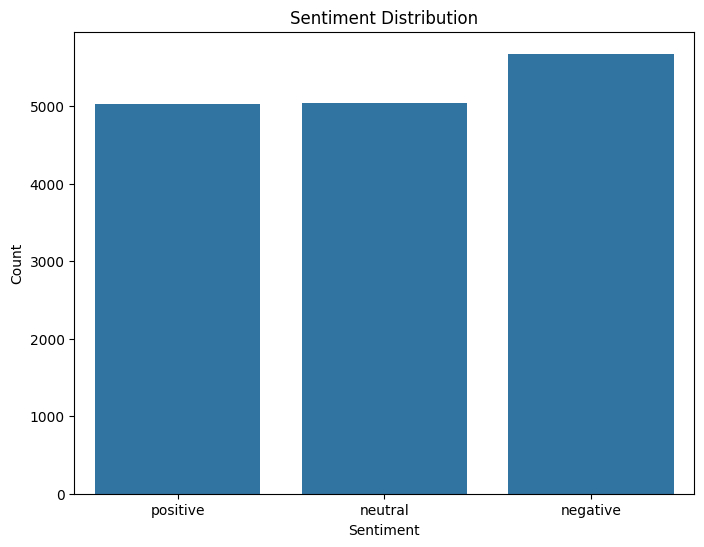

In [11]:
# Crear la figura y el gráfico de barras horizontal
sentiment_counts = df['sentiment'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Distribution")
plt.xticks(ticks=sentiment_counts.index, labels=class_names) # Set labels
plt.show()


In [12]:
sentences = df['content'].values
print("sentences shape:", sentences.shape)
sentences[:3]

sentences shape: (15746,)


array(["Update: After getting a response from the developer I would change my rating to 0 stars if possible. These guys hide behind confusing and opaque terms and refuse to budge at all. I'm so annoyed that my money has been lost to them! Really terrible customer experience. Original: Be very careful when signing up for a free trial of this app. If you happen to go over they automatically charge you for a full years subscription and refuse to refund. Terrible customer experience and the app is just OK.",
       'Used it for a fair amount of time without any problems. Suddenly then asked me to create an account or log using Google or FB. I used my Google one only to discover everything was gone!',
       "Your app sucks now!!!!! Used to be good but now doesn't update until I physically open it up and then close it then scroll and then it finally shows what I want to put on the list!!!!!! And I FRIGGEN paid for this garbage!!!!!!!"],
      dtype=object)

Median: 139.0


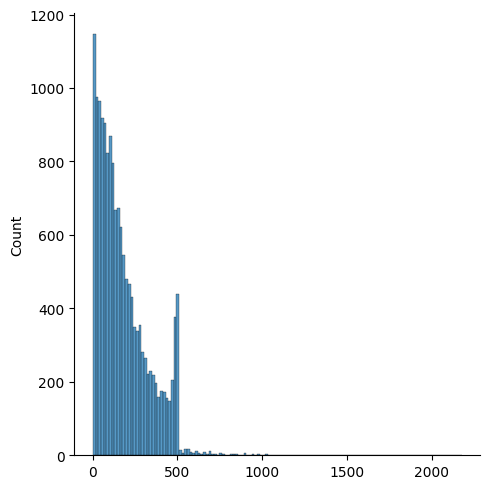

In [13]:
sentence_lens = []

for sentence in sentences:
  sentence_lens.append(len(sentence))

print("Median:", np.median(sentence_lens))
sns.displot(sentence_lens)

In [14]:
y = df['sentiment'].values
print("y shape:", y.shape)
y = to_categorical(y)
print(y[:3])
output_shape = y.shape[1]
print("output shape:", output_shape)

y shape: (15746,)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
output shape: 3


----
## Entrenamientos

### Entrenamiento con modelo de 3 categorias

Realizaremos dos entrenamientos variando el tamaño máximo de las sentencias: 140 y 350 tokens. Luego, compararemos los resultados obtenidos.

Es importante mencionar que los tamaños de batch estan limitados por las limitaciones de vRAM disponible.

#### Desarrollo modelo 1

```
max_lenght=140
output_shape = 3
```

In [15]:
max_length = 140
output_shape = 3

In [ ]:
# Importamos la primera parte: encoder
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
bert_model.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109482240 (417.64 MB)
Trainable params: 109482240 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
bert_model.bert.trainable = False

input_ids = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='input_ids')
attention_mask = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='attention_mask')

outputs = bert_model(input_ids, attention_mask=attention_mask)

pooled_output = outputs.pooler_output

x = tensorflow.keras.layers.Dropout(0.2)(pooled_output)
output = tensorflow.keras.layers.Dense(output_shape, activation='softmax')(x)

model_1 = tensorflow.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

model_1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',tensorflow.keras.metrics.F1Score(average='macro')])

In [ ]:
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 140)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 140)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 140, 7                                       

##### Generlo los datos para el tokenizador

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
indices = np.arange(len(sentences))
idx_train_val, idx_test = train_test_split(indices, test_size=0.2, random_state=42)
idx_train, idx_val = train_test_split(idx_train_val, test_size=0.2, random_state=42)

In [ ]:
print(idx_train.shape[0], idx_val.shape[0], idx_test.shape[0])

10076 2520 3150


In [ ]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(sentences, y, idx_train, idx_val)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), bert_tokenizer, max_length=max_length)
train_data = train_data.shuffle(100).batch(32)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), bert_tokenizer, max_length=max_length)
validation_data = validation_data.batch(32)

In [ ]:
pred_sentences = [sentences[i] for i in idx_test]
tf_batch = bert_tokenizer(pred_sentences, max_length=max_length, padding=True, truncation=True, return_tensors='tf')

In [ ]:
X_test = [tf_batch['input_ids'],
          tf_batch['attention_mask']]

In [ ]:
y_test = y[idx_test]

In [ ]:
# Entreno el modelo

history_model_1 = model_1.fit(train_data, epochs=7, validation_data=validation_data)

Epoch 1/7
315/315 [==============================] - 148s 420ms/step - loss: 1.1088 - accuracy: 0.3974 - f1_score: 0.3898 - val_loss: 0.9994 - val_accuracy: 0.5333 - val_f1_score: 0.5200
Epoch 2/7
315/315 [==============================] - 128s 406ms/step - loss: 1.0325 - accuracy: 0.4705 - f1_score: 0.4609 - val_loss: 0.9589 - val_accuracy: 0.5313 - val_f1_score: 0.5079
Epoch 3/7
315/315 [==============================] - 128s 408ms/step - loss: 0.9991 - accuracy: 0.4918 - f1_score: 0.4823 - val_loss: 0.9370 - val_accuracy: 0.5548 - val_f1_score: 0.4936
Epoch 4/7
315/315 [==============================] - 128s 408ms/step - loss: 0.9734 - accuracy: 0.5161 - f1_score: 0.5060 - val_loss: 0.9191 - val_accuracy: 0.5579 - val_f1_score: 0.4848
Epoch 5/7
315/315 [==============================] - 128s 406ms/step - loss: 0.9671 - accuracy: 0.5211 - f1_score: 0.5094 - val_loss: 0.9098 - val_accuracy: 0.5575 - val_f1_score: 0.4992
Epoch 6/7
315/315 [==============================] - 128s 405ms/s

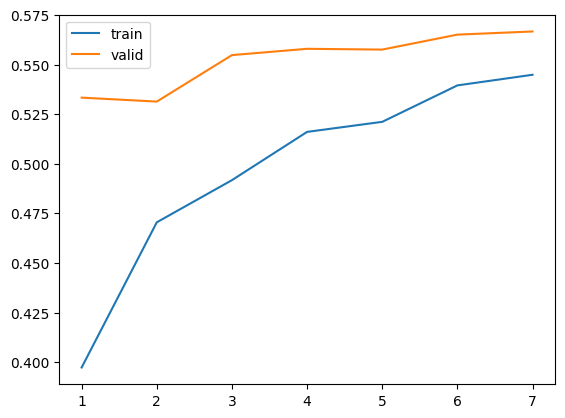

In [ ]:
plot_train_metrics(history_model_1)

In [ ]:
y_hat_prob = model_1.predict(X_test)
y_hat_prob[:3]

99/99 [==============================] - 35s 321ms/step


array([[0.59523803, 0.28822908, 0.11653291],
       [0.54468554, 0.2497677 , 0.20554675],
       [0.2667446 , 0.36740264, 0.36585277]], dtype=float32)

In [ ]:
y_hat = np.argmax(y_hat_prob, axis=1)

In [ ]:
scores = model_1.evaluate(X_test, y_test)
scores[1]

99/99 [==============================] - 33s 304ms/step - loss: 0.8991 - accuracy: 0.5870 - f1_score: 0.5482


0.5869840979576111

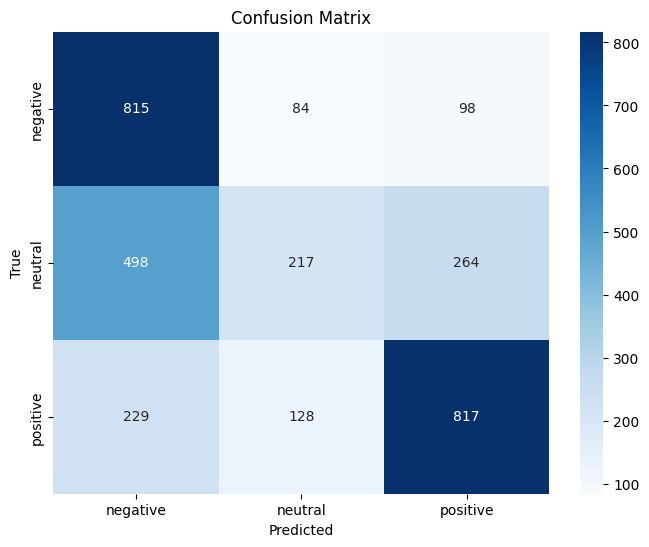

In [ ]:
cm = confusion_matrix(y_test.argmax(axis=1), y_hat)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

##### Fine-Tunning BERT

In [ ]:
# Colocar todas las layers como entrenables
for layer in model_1.layers:
  layer.trainable = True

model_1.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 140)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 140)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 140, 7                                       

In [ ]:
history_model_1_fine = model_1.fit(train_data, epochs=7, validation_data=validation_data)

Epoch 1/7
315/315 [==============================] - 335s 957ms/step - loss: 0.7462 - accuracy: 0.6590 - val_loss: 0.6805 - val_accuracy: 0.6968
Epoch 2/7
315/315 [==============================] - 295s 937ms/step - loss: 0.6116 - accuracy: 0.7274 - val_loss: 0.6321 - val_accuracy: 0.7175
Epoch 3/7
315/315 [==============================] - 296s 939ms/step - loss: 0.4736 - accuracy: 0.8055 - val_loss: 0.6531 - val_accuracy: 0.7532
Epoch 4/7
315/315 [==============================] - 295s 937ms/step - loss: 0.3264 - accuracy: 0.8716 - val_loss: 0.7059 - val_accuracy: 0.7897
Epoch 5/7
170/315 [===============>..............] - ETA: 2:04 - loss: 0.2220 - accuracy: 0.9151

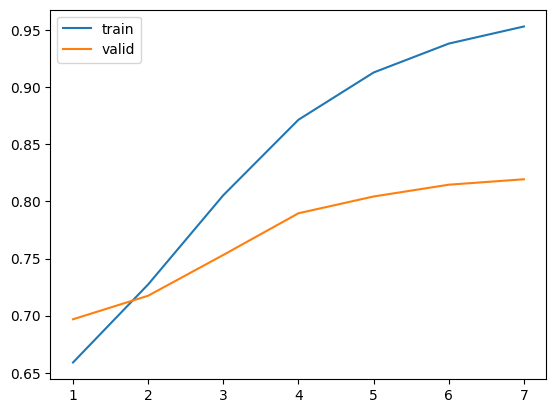

In [ ]:
plot_train_metrics(history_model_1_fine)

In [ ]:
y_hat_prob = model_1.predict(X_test)
y_hat_prob[:3]

99/99 [==============================] - 35s 322ms/step


array([[1.4874254e-01, 7.9914612e-01, 5.2111365e-02],
       [9.9727267e-01, 2.7261458e-03, 1.2193310e-06],
       [2.7000452e-03, 9.8727578e-01, 1.0024143e-02]], dtype=float32)

In [ ]:
y_hat = np.argmax(y_hat_prob, axis=1)

In [ ]:
scores = model_1.evaluate(X_test, y_test)
scores[1]

99/99 [==============================] - 33s 306ms/step - loss: 0.8562 - accuracy: 0.8225


0.8225396871566772

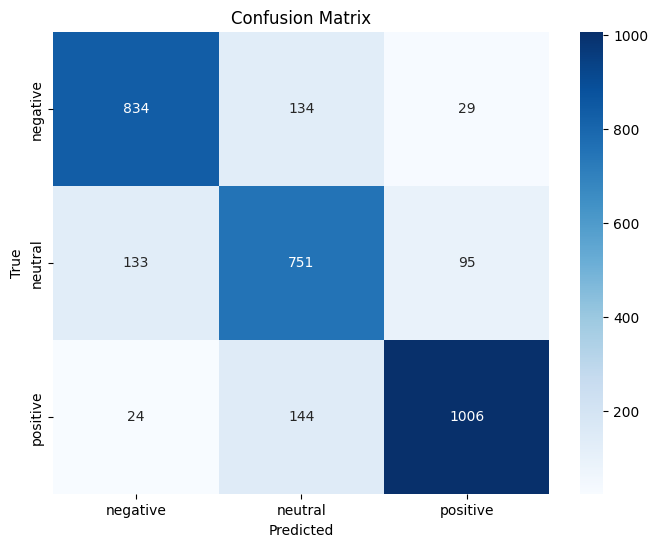

In [ ]:
cm = confusion_matrix(y_test.argmax(axis=1), y_hat)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Guardo el modelo
model_1.save_weights('bert_weights_model_1_fine_140.h5')

#### Desarrollo modelo 1 con max_lenght = 350

In [16]:
max_length = 350
output_shape = 3

In [17]:
# Importamos la primera parte: encoder
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [18]:
bert_model.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109482240 (417.64 MB)
Trainable params: 109482240 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
bert_model.bert.trainable = False

input_ids = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='input_ids')
attention_mask = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='attention_mask')

outputs = bert_model(input_ids, attention_mask=attention_mask)

pooled_output = outputs.pooler_output

x = tensorflow.keras.layers.Dropout(0.2)(pooled_output)
output = tensorflow.keras.layers.Dense(output_shape, activation='softmax')(x)

model_1 = tensorflow.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

model_1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',tensorflow.keras.metrics.F1Score(average='macro')])

In [20]:
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 350)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 350)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 350, 7                                       

##### Generlo los datos para el tokenizador

In [21]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [22]:
indices = np.arange(len(sentences))
idx_train_val, idx_test = train_test_split(indices, test_size=0.2, random_state=42)
idx_train, idx_val = train_test_split(idx_train_val, test_size=0.2, random_state=42)

In [23]:
print(idx_train.shape[0], idx_val.shape[0], idx_test.shape[0])

10076 2520 3150


In [29]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(sentences, y, idx_train, idx_val)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), bert_tokenizer, max_length=max_length)
train_data = train_data.shuffle(100).batch(32)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), bert_tokenizer, max_length=max_length)
validation_data = validation_data.batch(32)

In [30]:
pred_sentences = [sentences[i] for i in idx_test]
tf_batch = bert_tokenizer(pred_sentences, max_length=max_length, padding=True, truncation=True, return_tensors='tf')

In [31]:
X_test = [tf_batch['input_ids'],
          tf_batch['attention_mask']]

In [32]:
y_test = y[idx_test]

In [33]:
# Entreno el modelo

history_model_1_350 = model_1.fit(train_data, epochs=7, validation_data=validation_data)

Epoch 1/7
315/315 [==============================] - 382s 1s/step - loss: 1.1023 - accuracy: 0.4064 - f1_score: 0.4004 - val_loss: 1.0052 - val_accuracy: 0.5008 - val_f1_score: 0.4285
Epoch 2/7
315/315 [==============================] - 383s 1s/step - loss: 1.0384 - accuracy: 0.4589 - f1_score: 0.4492 - val_loss: 0.9640 - val_accuracy: 0.5190 - val_f1_score: 0.4627
Epoch 3/7
315/315 [==============================] - 384s 1s/step - loss: 0.9972 - accuracy: 0.4989 - f1_score: 0.4888 - val_loss: 0.9667 - val_accuracy: 0.5357 - val_f1_score: 0.4413
Epoch 4/7
315/315 [==============================] - 384s 1s/step - loss: 0.9676 - accuracy: 0.5222 - f1_score: 0.5118 - val_loss: 0.9303 - val_accuracy: 0.5484 - val_f1_score: 0.4841
Epoch 5/7
315/315 [==============================] - 384s 1s/step - loss: 0.9579 - accuracy: 0.5280 - f1_score: 0.5175 - val_loss: 0.9182 - val_accuracy: 0.5532 - val_f1_score: 0.4565
Epoch 6/7
315/315 [==============================] - 384s 1s/step - loss: 0.9417

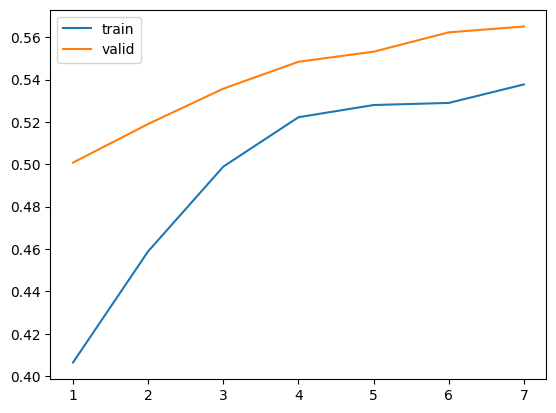

In [34]:
plot_train_metrics(history_model_1_350)

In [35]:
y_hat_prob = model_1.predict(X_test)
y_hat_prob[:3]

99/99 [==============================] - 94s 914ms/step


array([[0.47996464, 0.32988515, 0.19015022],
       [0.41055948, 0.26115438, 0.32828617],
       [0.22998507, 0.3278422 , 0.44217268]], dtype=float32)

In [36]:
y_hat = np.argmax(y_hat_prob, axis=1)

In [37]:
scores = model_1.evaluate(X_test, y_test)
scores[1]

99/99 [==============================] - 94s 913ms/step - loss: 0.8898 - accuracy: 0.5737 - f1_score: 0.5302


0.5736507773399353

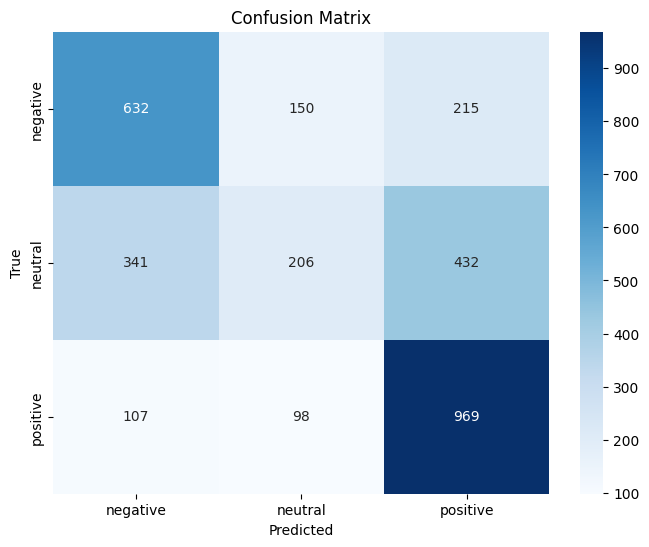

In [38]:
cm = confusion_matrix(y_test.argmax(axis=1), y_hat)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

##### Fine-Tunning BERT

In [39]:
# Colocar todas las layers como entrenables
for layer in model_1.layers:
  layer.trainable = True

model_1.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 350)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 350)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 350, 7                                       

In [40]:
from tensorflow.keras import backend as K
K.clear_session()

In [42]:
# Reduzco el batch size
train_data = train_data.unbatch().batch(16)
validation_data = validation_data.unbatch().batch(16)

In [43]:
history_model_1_fine_350 = model_1.fit(train_data, epochs=7, validation_data=validation_data)

Epoch 1/7
630/630 [==============================] - 864s 1s/step - loss: 0.7395 - accuracy: 0.6585 - val_loss: 0.6450 - val_accuracy: 0.7143
Epoch 2/7
630/630 [==============================] - 847s 1s/step - loss: 0.5770 - accuracy: 0.7459 - val_loss: 0.6245 - val_accuracy: 0.7429
Epoch 3/7
630/630 [==============================] - 849s 1s/step - loss: 0.4026 - accuracy: 0.8353 - val_loss: 0.7206 - val_accuracy: 0.7651
Epoch 4/7
630/630 [==============================] - 849s 1s/step - loss: 0.2491 - accuracy: 0.9027 - val_loss: 0.7314 - val_accuracy: 0.8036
Epoch 5/7
630/630 [==============================] - 848s 1s/step - loss: 0.1581 - accuracy: 0.9370 - val_loss: 0.8329 - val_accuracy: 0.8143
Epoch 6/7
630/630 [==============================] - 848s 1s/step - loss: 0.1142 - accuracy: 0.9554 - val_loss: 0.9409 - val_accuracy: 0.8206
Epoch 7/7
630/630 [==============================] - 848s 1s/step - loss: 0.0862 - accuracy: 0.9637 - val_loss: 0.9898 - val_accuracy: 0.8135


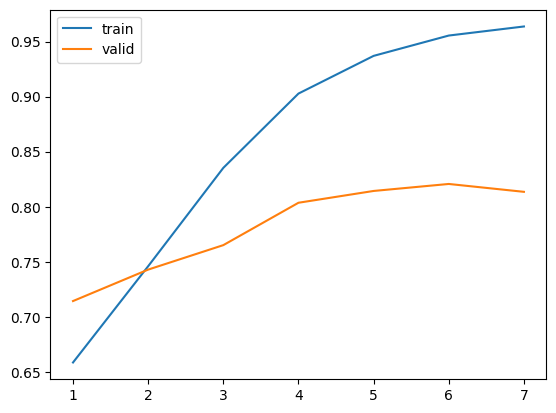

In [44]:
plot_train_metrics(history_model_1_fine_350)

In [45]:
y_hat_prob = model_1.predict(X_test)
y_hat_prob[:3]

99/99 [==============================] - 94s 916ms/step


array([[1.4273839e-01, 8.4386408e-01, 1.3397562e-02],
       [9.2631537e-01, 7.3636718e-02, 4.7872898e-05],
       [5.4379478e-03, 9.8186505e-01, 1.2697114e-02]], dtype=float32)

In [46]:
y_hat = np.argmax(y_hat_prob, axis=1)

In [47]:
scores = model_1.evaluate(X_test, y_test)
scores[1]

99/99 [==============================] - 94s 915ms/step - loss: 0.9463 - accuracy: 0.8222


0.8222222328186035

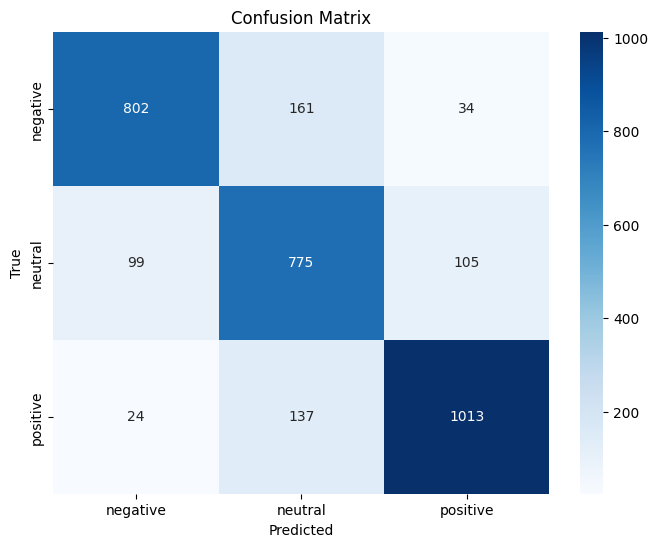

In [48]:
cm = confusion_matrix(y_test.argmax(axis=1), y_hat)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [49]:
# Guardo el modelo
model_1.save_weights('bert_weights_model_1_fine_350.h5')

####### CORTEEEEEE

In [ ]:
import tensorflow as tf
from transformers import TFBertModel
# Agregar capas adicionales y crear el modelo
x2 = tf.keras.layers.Dropout(0.2)(pooled_output)
dense2 = tf.keras.layers.Dense(bert_model.config.hidden_size, activation='relu')(x2)
output2 = tf.keras.layers.Dense(output_shape, activation='softmax')(dense2)

# Definir el modelo final
model_2 = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output2)

# Compilar el modelo
model_2.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy', tf.keras.metrics.F1Score(average='macro')])


In [ ]:
model_2.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 140)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 140)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 140, 7                                     

### Entrenamiento con modelo de 5 categorias


A continuación se realizara un modelo que tiene 5 categorias en vez de tres para la clasificación correspondiente al score otorgado a cada reseña.

Como primer paso voy a volver a preparar los datos para entrenamiento del mismo

#### Preparacón de los datos de entrenamiento para modelo con 5 *categorias*

In [50]:
df = pd.read_csv('reviews.csv')
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [51]:
print("Cantidad de críticas:", len(df))

Cantidad de críticas: 15746


<Axes: xlabel='score', ylabel='count'>

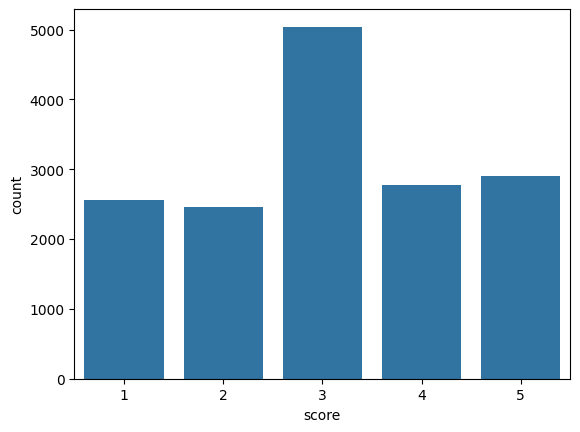

In [52]:
sns.countplot(x=df.score)

In [55]:
# En vez de balancer los datos, voy a considedad cada score como una clase para no agruparlo en 3 clases (negativo, neutro y positivo)
df['sentiment'] = df.score
class_names = [1, 2, 3, 4, 5]

In [56]:
sentences = df['content'].values
print("sentences shape:", sentences.shape)
sentences[:3]

sentences shape: (15746,)


array(["Update: After getting a response from the developer I would change my rating to 0 stars if possible. These guys hide behind confusing and opaque terms and refuse to budge at all. I'm so annoyed that my money has been lost to them! Really terrible customer experience. Original: Be very careful when signing up for a free trial of this app. If you happen to go over they automatically charge you for a full years subscription and refuse to refund. Terrible customer experience and the app is just OK.",
       'Used it for a fair amount of time without any problems. Suddenly then asked me to create an account or log using Google or FB. I used my Google one only to discover everything was gone!',
       "Your app sucks now!!!!! Used to be good but now doesn't update until I physically open it up and then close it then scroll and then it finally shows what I want to put on the list!!!!!! And I FRIGGEN paid for this garbage!!!!!!!"],
      dtype=object)

In [59]:
y = df['sentiment'].values -1
print("y shape:", y.shape)
y = to_categorical(y)
print(y[:3])
output_shape = y.shape[1]
print("output shape:", output_shape)

y shape: (15746,)
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
output shape: 5


#### Desarrollo modelo 1 (5 categorias) con max_lenght = 140

In [60]:
max_length = 140
output_shape = 5

In [61]:
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [62]:
bert_model.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109482240 (417.64 MB)
Trainable params: 109482240 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [63]:
bert_model.bert.trainable = False

input_ids = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='input_ids')
attention_mask = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='attention_mask')

outputs = bert_model(input_ids, attention_mask=attention_mask)

pooled_output = outputs.pooler_output

x = tensorflow.keras.layers.Dropout(0.2)(pooled_output)
output = tensorflow.keras.layers.Dense(output_shape, activation='softmax')(x)

model_1 = tensorflow.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

model_1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',tensorflow.keras.metrics.F1Score(average='macro')])

In [64]:
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 140)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 140)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 140, 7                                       

##### Generlo los datos para el tokenizador

In [65]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [66]:
indices = np.arange(len(sentences))
idx_train_val, idx_test = train_test_split(indices, test_size=0.2, random_state=42)
idx_train, idx_val = train_test_split(idx_train_val, test_size=0.2, random_state=42)

In [67]:
print(idx_train.shape[0], idx_val.shape[0], idx_test.shape[0])

10076 2520 3150


In [68]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(sentences, y, idx_train, idx_val)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), bert_tokenizer, max_length=max_length)
train_data = train_data.shuffle(100).batch(32)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), bert_tokenizer, max_length=max_length)
validation_data = validation_data.batch(32)

In [69]:
pred_sentences = [sentences[i] for i in idx_test]
tf_batch = bert_tokenizer(pred_sentences, max_length=max_length, padding=True, truncation=True, return_tensors='tf')

In [70]:
X_test = [tf_batch['input_ids'],
          tf_batch['attention_mask']]

In [71]:
y_test = y[idx_test]

In [72]:
# Entreno el modelo
history_model_1_5cat_140 = model_1.fit(train_data, epochs=7, validation_data=validation_data)

Epoch 1/7
315/315 [==============================] - 156s 452ms/step - loss: 1.5974 - accuracy: 0.2987 - f1_score: 0.2254 - val_loss: 1.5120 - val_accuracy: 0.3663 - val_f1_score: 0.2953
Epoch 2/7
315/315 [==============================] - 137s 435ms/step - loss: 1.5239 - accuracy: 0.3374 - f1_score: 0.2701 - val_loss: 1.4785 - val_accuracy: 0.3302 - val_f1_score: 0.2403
Epoch 3/7
315/315 [==============================] - 138s 437ms/step - loss: 1.4819 - accuracy: 0.3493 - f1_score: 0.2776 - val_loss: 1.4057 - val_accuracy: 0.4218 - val_f1_score: 0.3144
Epoch 4/7
315/315 [==============================] - 138s 437ms/step - loss: 1.4449 - accuracy: 0.3716 - f1_score: 0.3010 - val_loss: 1.3749 - val_accuracy: 0.4325 - val_f1_score: 0.3079
Epoch 5/7
315/315 [==============================] - 137s 436ms/step - loss: 1.4277 - accuracy: 0.3800 - f1_score: 0.3087 - val_loss: 1.3982 - val_accuracy: 0.3960 - val_f1_score: 0.3225
Epoch 6/7
315/315 [==============================] - 137s 436ms/s

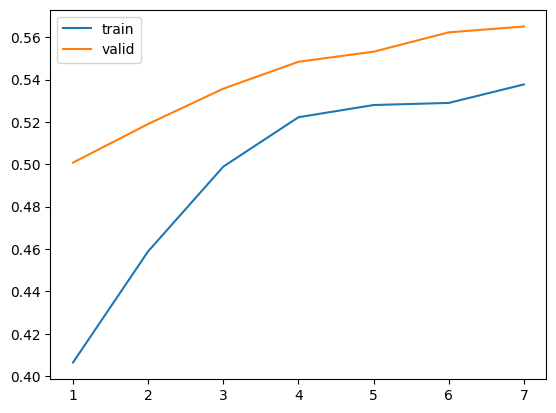

In [ ]:
plot_train_metrics(history_model_1_5cat_140)

In [73]:
y_hat_prob = model_1.predict(X_test)
y_hat_prob[:3]

99/99 [==============================] - 37s 338ms/step


array([[0.26183194, 0.34741578, 0.25857362, 0.0676263 , 0.0645524 ],
       [0.23422492, 0.32021248, 0.20321478, 0.10445417, 0.1378936 ],
       [0.10741246, 0.22188385, 0.29614508, 0.19739333, 0.17716524]],
      dtype=float32)

In [74]:
y_hat = np.argmax(y_hat_prob, axis=1)

In [75]:
scores = model_1.evaluate(X_test, y_test)
scores[1]

99/99 [==============================] - 36s 333ms/step - loss: 1.3598 - accuracy: 0.4032 - f1_score: 0.3619


0.40317460894584656

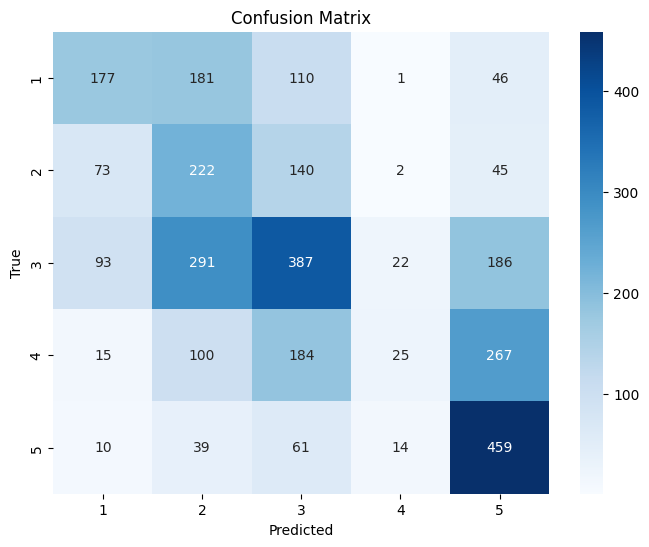

In [76]:
cm = confusion_matrix(y_test.argmax(axis=1), y_hat)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

##### Fine-Tunning BERT

In [77]:
# Colocar todas las layers como entrenables
for layer in model_1.layers:
  layer.trainable = True

model_1.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 140)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 140)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 140, 7                                       

In [78]:
history_model_1_5cat_140_fine = model_1.fit(train_data, epochs=7, validation_data=validation_data)

Epoch 1/7
315/315 [==============================] - 353s 1s/step - loss: 1.1420 - accuracy: 0.5112 - val_loss: 1.0593 - val_accuracy: 0.5520
Epoch 2/7
315/315 [==============================] - 314s 996ms/step - loss: 0.9739 - accuracy: 0.5854 - val_loss: 1.0198 - val_accuracy: 0.5881
Epoch 3/7
315/315 [==============================] - 313s 995ms/step - loss: 0.8255 - accuracy: 0.6591 - val_loss: 1.0362 - val_accuracy: 0.6107
Epoch 4/7
315/315 [==============================] - 314s 996ms/step - loss: 0.6495 - accuracy: 0.7409 - val_loss: 1.0778 - val_accuracy: 0.6429
Epoch 5/7
315/315 [==============================] - 314s 997ms/step - loss: 0.4835 - accuracy: 0.8163 - val_loss: 1.1246 - val_accuracy: 0.6778
Epoch 6/7
315/315 [==============================] - 313s 995ms/step - loss: 0.3602 - accuracy: 0.8632 - val_loss: 1.1740 - val_accuracy: 0.7067
Epoch 7/7
315/315 [==============================] - 314s 996ms/step - loss: 0.2640 - accuracy: 0.9030 - val_loss: 1.3563 - val_accur

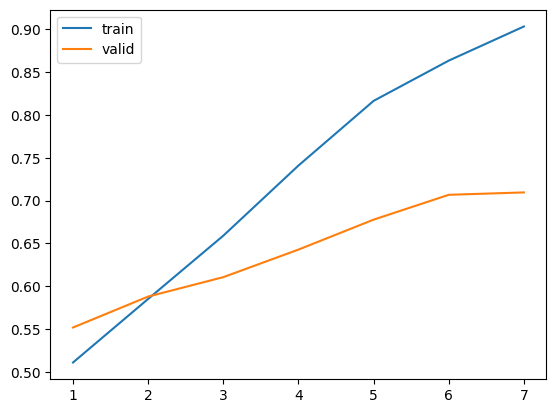

In [79]:
plot_train_metrics(history_model_1_5cat_140_fine)

In [80]:
y_hat_prob = model_1.predict(X_test)
y_hat_prob[:3]

99/99 [==============================] - 36s 332ms/step


array([[3.0871565e-03, 1.2603298e-01, 5.0646633e-01, 3.6364767e-01,
        7.6585752e-04],
       [7.2546232e-01, 2.7315965e-01, 1.3764885e-03, 7.4186397e-07,
        8.2112319e-07],
       [3.6184058e-05, 3.2634470e-03, 5.8219749e-01, 4.1365662e-01,
        8.4630057e-04]], dtype=float32)

In [81]:
y_hat = np.argmax(y_hat_prob, axis=1)

In [82]:
scores = model_1.evaluate(X_test, y_test)
scores[1]

99/99 [==============================] - 37s 333ms/step - loss: 1.2847 - accuracy: 0.7048


0.7047619223594666

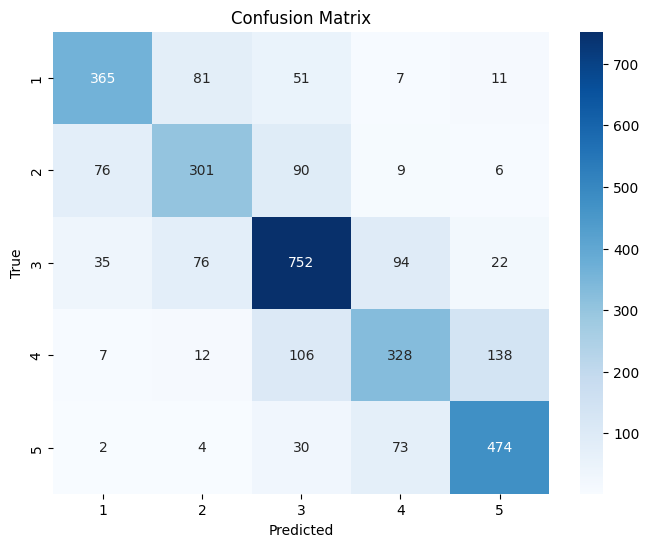

In [83]:
cm = confusion_matrix(y_test.argmax(axis=1), y_hat)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [84]:
# Guardo el modelo
model_1.save_weights('bert_weights_model_1_5cat_fine_140.h5')

## Probar el modelo

In [87]:
bert_model3 = TFBertModel.from_pretrained("bert-base-uncased")

input_ids = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='input_ids')

# attention_mask - is a binary mask which tells BERT which tokens to attend and which not to attend.
# Encoder will add the 0 tokens to the some sequence which smaller than MAX_SEQUENCE_LENGTH,
# and attention_mask, in this case, tells BERT where is the token from the original data and where is 0 pad token:
attention_mask = tensorflow.keras.layers.Input((max_length,), dtype=tensorflow.int32, name='attention_mask')

# Get the pooled_output (embedding que representa toda la entrada)
output = bert_model3([input_ids, attention_mask])[1]

# We can also add dropout as regularization technique:
output = tensorflow.keras.layers.Dropout(rate=0.2)(output)

# Se puede agregar más capas Densas en el medio si se desea

# Provide number of classes to the final layer:
output = tensorflow.keras.layers.Dense(output_shape, activation='softmax')(output)

# Final model:
model_to_test = tensorflow.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [88]:
model_to_test.load_weights('bert_weights_model_1_5cat_fine_140.h5')

## Ensayo

In [89]:
text = "I love this app!"

tf_batch = bert_tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    max_length=max_length, # truncates if len(s) > max_length
    return_token_type_ids=False,
    return_attention_mask=True,
    pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
    truncation=True,
    return_tensors='tf'
)

print("Inputs ids:", tf_batch['input_ids'])
print("Attention mask:", tf_batch['attention_mask'])

Inputs ids: tf.Tensor(
[[  101  1045  2293  2023 10439   999   102     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]], shape=(1, 140), dtype=int32)
Attention mask: tf.Tensor(
[[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [90]:
X_ensayo = [tf_batch['input_ids'],
          tf_batch['attention_mask']]

In [91]:
y_prob_ensayo = model_to_test.predict(X_ensayo)
y_prob = np.argmax(y_prob_ensayo, axis=1)
print("Clasificación:", class_names[int(y_prob)])

1/1 [==============================] - 3s 3s/step
Clasificación: 5


<ipython-input-91-f9722feb9206>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Clasificación:", class_names[int(y_prob)])


Creo unas pruebas de texto para probar el modelo:

In [92]:
texts_input = [
    "This app exceeded my expectations!",
    "One of the worst apps I've used.",
    "It's a decent app, but it could be better.",
    "Absolutely delighted with this app.",
    "Total disappointment, wouldn't recommend.",
    "This app is quite impressive.",
    "I can't stand this app.",
    "It gets the job done, nothing more."
]

for text in texts_input:
  tf_batch = bert_tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=max_length, # truncates if len(s) > max_length
      return_token_type_ids=False,
      return_attention_mask=True,
      pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
      truncation=True,
      return_tensors='tf'
  )
  X_ensayo = [tf_batch['input_ids'],tf_batch['attention_mask']]
  y_prob_ensayo = model_to_test.predict(X_ensayo)
  y_prob = np.argmax(y_prob_ensayo, axis=1)
  print("Texto:", text)
  print("Clasificación:", class_names[int(y_prob)])
  print("----------------------------")


1/1 [==============================] - 0s 58ms/step


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
<ipython-input-92-398183af36b2>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Clasificación:", class_names[int(y_prob)])


Texto: This app exceeded my expectations!
Clasificación: 5
----------------------------
1/1 [==============================] - 0s 56ms/step
Texto: One of the worst apps I've used.
Clasificación: 1
----------------------------
1/1 [==============================] - 0s 55ms/step
Texto: It's a decent app, but it could be better.
Clasificación: 3
----------------------------
1/1 [==============================] - 0s 55ms/step
Texto: Absolutely delighted with this app.
Clasificación: 5
----------------------------
1/1 [==============================] - 0s 55ms/step
Texto: Total disappointment, wouldn't recommend.
Clasificación: 1
----------------------------
1/1 [==============================] - 0s 58ms/step
Texto: This app is quite impressive.
Clasificación: 5
----------------------------
1/1 [==============================] - 0s 57ms/step
Texto: I can't stand this app.
Clasificación: 1
----------------------------
1/1 [==============================] - 0s 57ms/step
Texto: It gets the job

## Conclusiones

Este trabajo analizó el uso de BERT para la tarea de clasificación de sentimientos en un dataset de reseñas de aplicaciones. Para el desarrollo de los modelos de 3 categorías y 5 categorías, se abordaron principalmente dos estrategias: *fine-tuning* y *transfer learning*.

- **Transfer Learning:**

  - Se obtuvo un rendimiento satisfactorio en la clasificación de sentimientos, superando a modelos básicos en términos de precisión.
  - La estrategia de *transfer learning* permitió utilizar el conocimiento preentrenado de BERT, evitando la necesidad de entrenar todos los parámetros desde cero.

- **Fine-Tuning:**

  - El *fine-tuning* resultó en una mejora adicional en la precisión y la capacidad de generalización del modelo, aunque se observó una ligera tendencia al *overfitting*.

### Notas sobre la comparación entre el modelo de 3 categorías vs 5:

- En el modelo de 5 categorías, el rendimiento del modelo se redujo debido a la mayor dificultad que implica clasificar en más categorías.
- El *overfitting* continuó siendo un problema, y el modelo no pudo generalizar bien, lo que podría estar relacionado con la complejidad añadida al clasificar en un mayor número de categorías.

### Trabajos a futuro:
- Aplicar técnicas de regularización para reducir el *overfitting*, como ampliar el conjunto de datos o incrementar el uso de capas de *dropout*.
- Ajuste de hiperparámetros y modificación de la arquitectura del modelo para mejorar el rendimiento.
